# House Prices: Advanced Regression Techniques

    By Charlie Marshall
    Prof. Katsagellis
    EECS 375
    29 May 2020

# Report Conclusions:

I generally enjoyed working with this dataset and dealing with the challenges that it approaches. The two things I found most challenging were engineering the features of the dataset and tuning the parameters of the XGBoost algorithm.

First, I found that this practice was great practice in feature engineering. For a few of the features, many of the values were Null, so I had to make decisions about how to deal with these variables in order for them to be useful for prediction. In the case of many of the categorical variables, the fact that it was null simply signalled that the factor was not present in the property. For instance, if there was no pool on the property, all the variables concerning a pool would be null. For some continuous variables, different techniques such as replacing missing values with the mean were used. Additionally, some feature engineering needed to be done to improve the format of the data for predictive modeling. This included applying a Label Encoder to categorical variables so that they could be handled by the model and transforming many of the factors, including the SalePrice so that they more closely resembled a normal distribution.

Next, I enjoyed using the XGBoost algorithm in order to predict the Sale Price of the test properties. I had never used the XGBoost algorithm before and it was exciting to see the performance and to use a method that I know is used often in industry. Although the algorithm is not hard to implement, it is harder to tune the parameters of the algorithm so that the predictions are correct on both the training and testing data. In the end, I was able to obtain an RMSE of 0.08 and an RSE 0.006. I would consider this good performance relative to the RMSE values I was getting when I first fit the model which were greater than 100. One thing that I noticed when optimizing the parameters was that although I might improve the RMSE metric for the training set, the model might not perform better on the testing set. This is most likely due to overfitting the training data. In the future, I will focus more on making sure my model is resilient and able to predict all data accurately.

Although the report was supposed to be only 5 pages, I have included my code as an appendix to this report. There are comments at important points throughout the code, but they mainly mimick the sentiment in this report.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder  

# Load Data

Loading in data, which is already in the form of a training and testing set. The training set includes a SalePrice for each property while the testing set does not.

In [2]:
train = pd.read_csv('/Users/charlesmarshall/Desktop/ELEC_ENG375/FinalProject/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/charlesmarshall/Desktop/ELEC_ENG375/FinalProject/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [4]:
train.shape

(1460, 80)

In [5]:
test.shape

(1459, 79)

# Exploratory Data Analysis

## Outliers

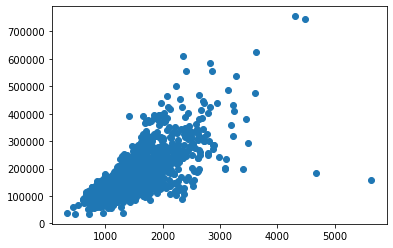

In [6]:
plt.scatter(train['GrLivArea'], train['SalePrice'])

The two points in the bottom right corner are obvious outliers because they do not follow the general linear, upward trend of the other datapoints. In order to not skew the model towards these points, they should be dropped from the training set.

In [7]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

All data points now generally follow a linear, upward trend.

## Analysis of Skew


 mu = 180932.92 and sigma = 79467.79



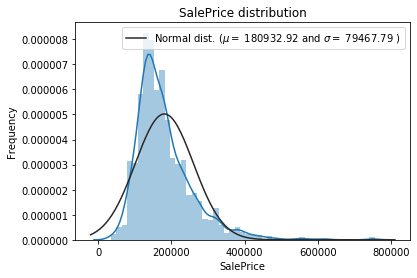

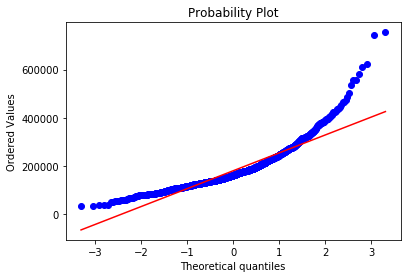

In [8]:
sns.distplot(train.SalePrice, fit = norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Applying a log transformation


 mu = 12.02 and sigma = 0.40



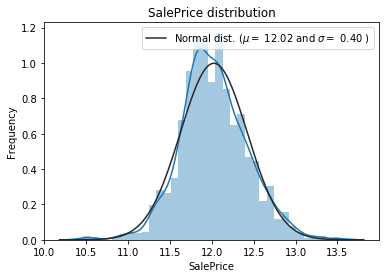

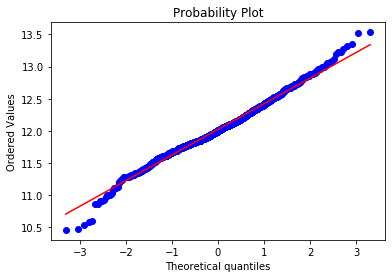

In [9]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


Before the log transform is applied, the data is obviously skewed right and the data eviated greatly from the probability plot at both tails. Once the log transform is applied, the deviation of the data decreases greatly and the prob plot line is followed much closer, with smaller deviations at the tails.

# Missing Values

NA values in the data must be dealt with in order to correctly analyze the data. In the case of some categorical variables, an NA value means there is no case of a certain characteristic on the property. In the case of continous factors, more complex analysis must be done for each variable. Specific action was determined based on the data description.

## Combining data

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

In [11]:
all_housing = pd.concat((train, test)).reset_index(drop=True)

In [12]:
all_housing.drop(['SalePrice'], axis=1, inplace=True)

In [13]:
all_housing.shape

(2917, 79)

In [14]:
## Number of Missing Data Points by Factor: (commented to save space in report)

#all_housing.isnull().sum().sort_values(ascending=False)[0:34]

## PoolQC

When NA, it means there is no pool at the house.

In [15]:
all_housing["PoolQC"] = all_housing["PoolQC"].fillna("None")

## MiscFeature

When NA, there are no miscellaneous features not covered in other categories.

In [16]:
all_housing["MiscFeature"] = all_housing["MiscFeature"].fillna("None")

## Alley

When NA, there is no alley access to the property

In [17]:
all_housing["Alley"] = all_housing["Alley"].fillna("None")

## Fence

When NA, there is no fence

In [18]:
all_housing["Fence"] = all_housing["Fence"].fillna("None")

## FireplaceQu

When NA, there is no fireplace.

In [19]:
all_housing["FireplaceQu"] = all_housing["FireplaceQu"].fillna("None")

## LotFrontage

When NA, use median value

In [20]:
all_housing["LotFrontage"] = all_housing.groupby('Neighborhood')["LotFrontage"].fillna(all_housing["LotFrontage"].median())

## Garage Variables:

If NA, the property does not have a garage. For categorical variables, NA changed to None. Fot continous, NA changed to 0.

In [21]:
# Categorical
all_housing["GarageCond"] = all_housing["GarageCond"].fillna("None")
all_housing["GarageType"] = all_housing["GarageType"].fillna("None")
all_housing["GarageFinish"] = all_housing["GarageFinish"].fillna("None")
all_housing["GarageQual"] = all_housing["GarageQual"].fillna("None")

In [22]:
# Continuous
all_housing["GarageYrBlt"] = all_housing["GarageYrBlt"].fillna(0)
all_housing["GarageCars"] = all_housing["GarageCars"].fillna(0)
all_housing["GarageArea"] = all_housing["GarageArea"].fillna(0)

## Basement Variables

If NA, the property does not have a basement. For categorical variables, NA changed to None.

In [23]:
# Categorical
all_housing["BsmtQual"] = all_housing["BsmtQual"].fillna("None")
all_housing["BsmtCond"] = all_housing["BsmtCond"].fillna("None")
all_housing["BsmtExposure"] = all_housing["BsmtExposure"].fillna("None")
all_housing["BsmtFinType1"] = all_housing["BsmtFinType1"].fillna("None")
all_housing["BsmtFinType2"] = all_housing["BsmtFinType2"].fillna("None")

In [24]:
# Continuous
all_housing["BsmtFinSF1"] = all_housing["BsmtFinSF1"].fillna(0)
all_housing["BsmtFinSF2"] = all_housing["BsmtFinSF2"].fillna(0)
all_housing["BsmtUnfSF"] = all_housing["BsmtUnfSF"].fillna(0)
all_housing["TotalBsmtSF"] = all_housing["TotalBsmtSF"].fillna(0)
all_housing["BsmtFullBath"] = all_housing["BsmtFullBath"].fillna(0)
all_housing["BsmtHalfBath"] = all_housing["BsmtHalfBath"].fillna(0)

## Masonry Variables

When NA, change to None or 0.

In [25]:
all_housing["MasVnrType"] = all_housing["MasVnrType"].fillna("None")
all_housing["MasVnrArea"] = all_housing["MasVnrArea"].fillna(0)

## Other Variables

In [26]:
all_housing['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [27]:
all_housing["MSZoning"] = all_housing["MSZoning"].fillna('RL')
all_housing["Functional"] = all_housing["Functional"].fillna('Typ')
all_housing = all_housing.drop(['Utilities'], axis=1)
all_housing["SaleType"] = all_housing["SaleType"].fillna('WD')
all_housing["Exterior1st"] = all_housing["Exterior1st"].fillna('VinylSd')
all_housing["Electrical"] = all_housing["Electrical"].fillna('SBrkr')
all_housing["KitchenQual"] = all_housing["KitchenQual"].fillna('TA')
all_housing["Exterior2nd"] = all_housing["Exterior2nd"].fillna('VinylSd')

# Feature Engineering

In [28]:
all_housing['MSSubClass']=all_housing['MSSubClass'].apply(str)
all_housing['OverallQual']=all_housing['OverallQual'].apply(str)
all_housing['OverallCond']=all_housing['OverallCond'].apply(str)
all_housing['MoSold'] = all_housing['MoSold'].astype(str)
all_housing['YrSold'] = all_housing['YrSold'].astype(str)

In [29]:
categorial_features = all_housing.select_dtypes(include=[np.object])

In [30]:
all_housing['TotalSF'] = all_housing['TotalBsmtSF'] + all_housing['1stFlrSF'] + all_housing['2ndFlrSF']

## Dealing with Categorical Variables:

In [31]:
#all_housing = pd.get_dummies(all_housing)

In [32]:
from sklearn.preprocessing import LabelEncoder

# process columns, apply LabelEncoder to categorical features
for c in categorial_features:
    lbl = LabelEncoder() 
    lbl.fit(list(all_housing[c].values)) 
    all_housing[c] = lbl.transform(list(all_housing[c].values))

In [33]:
all_housing.shape

(2917, 79)

## Dealing with Skewness:

Applying a Box-Cox Transformation to numerical features to transform skewed features to normally distributed features. Since there is the assumption of normality in many ML models, transforming the data to normal distribution often imporves performance.

In [34]:
numeric_feats = all_housing.dtypes[all_housing.dtypes != "object"].index
skewed_feats = all_housing[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

In [35]:
skewness = skewness[abs(skewness) > 0.75]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_housing[feat] = boxcox1p(all_housing[feat], lam)

# Modeling

In [36]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [37]:
train = all_housing[:ntrain]
test = all_housing[ntrain:]

In [38]:
#model = xgboost.XGBRegressor(learning_rate=0.5, 
                             #max_depth=10,
                             #n_estimators=2000,
                             #subsample=0.8,
                             #colsample_bytree=1,
                             #gamma = 1,
                             #nthread=-1
                            #)

In [39]:
#model = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             #learning_rate=0.05, max_depth=3, 
                             #min_child_weight=1.7817, n_estimators=2200,
                             #reg_alpha=0.4640, reg_lambda=0.8571,
                             #subsample=0.5213, silent=1,
                             #random_state =7, nthread = -1)

In [44]:
regressor=xgboost.XGBRegressor()

In [45]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [46]:
## Hyper Parameter Optimization


n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [47]:
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [48]:
random_cv.fit(train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 12.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                   iid='deprecated', n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbt

In [68]:
#random_cv.best_estimator_

XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [40]:
# Hyper parameters found from RandomizedSearchCV, do not run it again it takes ~13 minutes
model = xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                    importance_type='gain', interaction_constraints=None,
                    learning_rate=0.1, max_delta_step=0, max_depth=2,
                    min_child_weight=1, missing=np.nan, monotone_constraints=None,
                    n_estimators=900, n_jobs=0, num_parallel_tree=1,
                    objective='reg:squarederror', random_state=0, reg_alpha=0,
                    reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
                    validate_parameters=False, verbosity=None)

In [69]:
#model=random_cv.best_estimator_
#model

XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [41]:
model.fit(train, y_train)
train_pred = model.predict(train)
test_pred = model.predict(test)

In [42]:
train_pred = model.predict(train)
test_pred = np.expm1(model.predict(test))

In [43]:
train_pred

array([12.24247  , 12.095531 , 12.297196 , ..., 12.504904 , 11.857472 ,
       11.9352455], dtype=float32)

In [44]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [45]:
mean_squared_error(y_train, train_pred)

0.003213268164510873

In [46]:
mean_absolute_error(y_train, train_pred)

0.04093463359844314

In [47]:
rmsle(y_train, train_pred)

0.056685696295545956

In [48]:
test_pred

array([125117.16 , 161936.16 , 195361.75 , ..., 161743.08 , 114910.164,
       225341.02 ], dtype=float32)

In [49]:
submission = pd.read_csv('/Users/charlesmarshall/Desktop/ELEC_ENG375/FinalProject/house-prices-advanced-regression-techniques/sample_submission.csv')
submission['SalePrice'] = test_pred
submission = submission.set_index('Id')

In [50]:
submission.to_csv('submission.csv')